# Modelling and Evaluation Notebook

## Objectives

* Rebuild data generators with batch size = 32 (same augmentation as Step 1 for training; rescale only for validation/test).
* Load the top 5 scenarios from Step 1 and prepare them for retraining.
* Create the CNN model for each selected scenario.
* Fit each model (EarlyStopping + best‐model checkpoint).
* Evaluate each run on the validation set and collect: loss, accuracy, precision, recall, F1, and a confusion matrix.
* Build a simple leaderboard to compare runs and pick the top candidates for the next step.
  

## Inputs

* inputs/mildew-dataset/cherry-leaves/train
* inputs/mildew-dataset/cherry-leaves/test
* inputs/mildew-dataset/cherry-leaves/validation
* image shape embeddings
* Step-1 leaderboard (outputs/step_1/reports/grid_report_bs16.csv) to select the top 5 configurations

## Outputs
* Best-epoch model files per scenario.
* Training histories.
* Learning-curve plots (accuracy/loss).
* Validation metrics per run. (loss, accuracy, precision, recall, F1, confusion matrix)
* Consolidated leaderboard for Step 2. (sorted by validation accuracy, tie-break by validation loss)
* Shortlist (top 3) ready for test-set evaluation in the final step

## Additional Comments | Insights | Conclusions

---

## Import Libraries

In [54]:

import os, math, json, itertools, time, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from pathlib import Path

# TensorFlow and Keras:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

---

## Set Seed

In [55]:
SEED = 27
np.random.seed(SEED)
tf.random.set_seed(SEED)

---

## Define Main Variables

In [56]:
version = 'step_3'

# Set batch size
batch_size = 32

# Set number of epochs
epochs = 25


---

# Set Directories

  ## Set Working Directory

In [57]:
# Parent directory
parent_dir =  "/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector"

# Change working directory to parent directory
os.chdir(parent_dir)
print (f"New working directory: {os.getcwd()} ")

New working directory: /Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector 


## Set Input Directory

In [58]:
dataset_dir = "inputs/mildew-dataset/cherry-leaves"
train_dir = os.path.join(parent_dir, dataset_dir, "train")
validation_dir = os.path.join(parent_dir, dataset_dir, "validation")
test_dir = os.path.join(parent_dir, dataset_dir, "test")

## Set Output Directory

In [59]:

file_path = f'outputs/{version}'

# Create main output directory if it doesn’t exist
if 'outputs' in os.listdir(parent_dir) and version in os.listdir(parent_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

# Define subfolders and ensure they exist:
models_dir = os.path.join(file_path, 'models')
reports_dir = os.path.join(file_path, 'reports')

os.makedirs(models_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)


Old version is already available create a new version.


### Get Artifact Paths:

In [60]:
def get_artifact_paths(models_dir: str, reports_dir: str, tag: str) -> dict:
    """
    Return file paths (no new dirs) for this run's artifacts, using the tag in filenames.
    """
    return {
        "model_path":   Path(models_dir)  / f"{tag}.keras",
        "history_pkl":  Path(reports_dir) / f"history_{tag}.pkl",
        "evaluation_pkl": Path(reports_dir) / f"eval_{tag}.pkl",
        "curve_png":    Path(reports_dir) / f"curves_{tag}.png",
    }

---

## Load  Top 3 Scenarios from Batch 32 Run:

In [61]:
prev_version = "step_2"  # adjust to your step_2 folder name
df_prev = pd.read_csv(f"outputs/{prev_version}/reports/grid_report_bs32.csv")

# same ranking rule as before
df_prev = df_prev.sort_values(by=["val_accuracy", "val_loss"], ascending=[False, True]).reset_index(drop=True)

TOP_N = 3 

df_top3 = df_prev.head(TOP_N).copy()

---

## Set Labels

In [62]:
# Set the labels
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [63]:
## Import saved image shape embedding
import joblib
image_shape = joblib.load(filename=f"outputs/v1/image_shape.pkl") # Set from previous run
image_shape

(256, 256, 3)

---

# Image Data Augmentation

### Image Data Generator

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [65]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Augment image datasets

In [66]:
# Test Set:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )


test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Save class_indices

In [67]:
joblib.dump(value=test_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/step_3/class_indices.pkl']

---

## Confusion Matrix

In [68]:
def plot_and_save_confusion_matrix(y_true, y_pred, class_names, out_path, title=None, show=True):
    """
    Plot a confusion matrix,  display it inline, and save to disk.
    Returns the numpy CM array.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4.5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='summer', colorbar=False, ax=ax)
    if title:
        ax.set_title(title)
    fig.tight_layout()

    if show: 
        plt.show()

    fig.savefig(out_path, dpi=140) # save the figure
    plt.close(fig)
    return cm

### Evaluate on Test Set

In [69]:
def evaluate_on_test(model, test_set, classes, threshold=0.5):
    """
    Returns dict with loss, accuracy, precision, recall, f1, confusion matrix, and classification report text.
    """
    # Keras loss & accuracy
    test_set.reset()
    loss, acc = model.evaluate(test_set, verbose=0)

    # Probabilities -> hard preds
    test_set.reset()
    y_prob = model.predict(test_set, verbose=0).squeeze()     # (N,)
    y_true = test_set.classes                                 # (N,)
    y_pred = (y_prob >= threshold).astype(int)

    # PRF for positive class=1 (adjust pos_label if your positive class is 0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Text report (human-readable, optional)
    report_txt = classification_report(y_true, y_pred, target_names=classes, zero_division=0)

    return {
        "test_loss": float(loss),
        "test_accuracy": float(acc),
        "test_precision": float(prec),
        "test_recall": float(rec),
        "test_f1": float(f1),
        "y_true": y_true,
        "y_pred": y_pred,
        "report_txt": report_txt
    }

## Execute Evaluation


=== [1/3] Evaluating on TEST: step_2_bs32_k3_do0.3_act-relu_opt-adamax_seed27 ===


/Users/marcelldemeter/GIT/CodeInstitute/ci-p5-mildew-detector/mildew-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


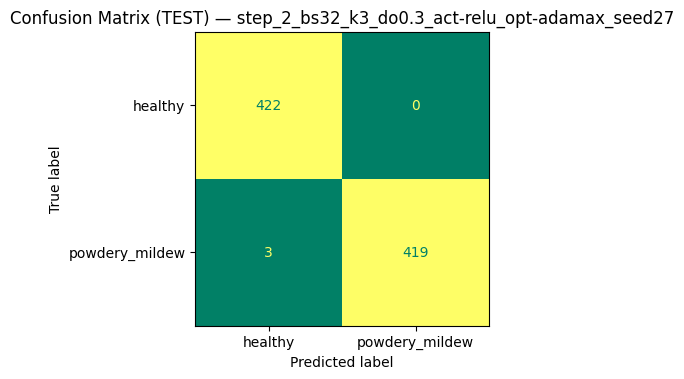


=== [2/3] Evaluating on TEST: step_2_bs32_k3_do0.3_act-elu_opt-adamax_seed27 ===


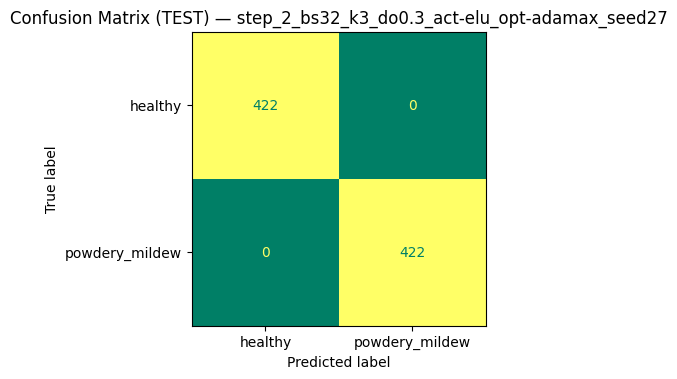


=== [3/3] Evaluating on TEST: step_2_bs32_k5_do0.5_act-elu_opt-adamax_seed27 ===


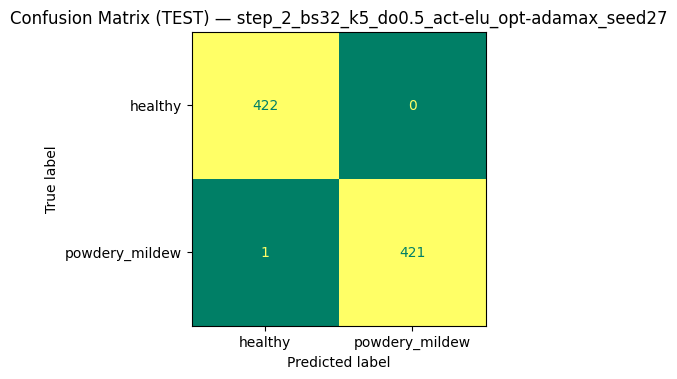


Finished TEST evaluation for 3 models in ~0.2 min


In [70]:
step2_models_dir = "outputs/step_2/models"

class_indices = test_set.class_indices
classes = [k for k, _ in sorted(class_indices.items(), key=lambda kv: kv[1])]

results = []
t0 = time.time()

for i, row in df_top3.iterrows():
    tag = row["tag"]
    model_path = os.path.join(step2_models_dir, f"{tag}.keras")
    assert os.path.exists(model_path), f"Model file not found: {model_path}"

    print(f"\n=== [{i+1}/{TOP_N}] Evaluating on TEST: {tag} ===")
    model = load_model(model_path)

    # Evaluate
    metrics = evaluate_on_test(model, test_set, classes, threshold=0.5)

    # Confusion matrix plot
    cm_png = os.path.join(reports_dir, f"cm_test_{tag}.png")
    cm = plot_and_save_confusion_matrix(
        y_true=metrics["y_true"],
        y_pred=metrics["y_pred"],
        class_names=classes,
        out_path=cm_png,
        title=f"Confusion Matrix (TEST) — {tag}",
        show=True
    )

    # Persist per-model text report (optional)
    report_txt_path = os.path.join(reports_dir, f"cls_report_test_{tag}.txt")
    with open(report_txt_path, "w") as f:
        f.write(metrics["report_txt"])

    # Row for the final CSV
    results.append({
        "tag": tag,
        "dropout": row["dropout"],
        "kernel_size": row["kernel_size"],
        "activation": row["activation"],
        "optimizer": row["optimizer"],
        "test_loss": metrics["test_loss"],
        "test_accuracy": metrics["test_accuracy"],
        "test_precision": metrics["test_precision"],
        "test_recall": metrics["test_recall"],
        "test_f1": metrics["test_f1"],
        "cm_png": cm_png,
        "model_path": model_path,
        "report_txt": report_txt_path
    })

elapsed = (time.time() - t0) / 60
print(f"\nFinished TEST evaluation for {TOP_N} models in ~{elapsed:.1f} min")


## Save the test leaderboard .csv and preview

In [71]:
df_test = pd.DataFrame(results).sort_values(
    by=["test_accuracy", "test_loss"], ascending=[False, True]
).reset_index(drop=True)

test_csv = os.path.join(reports_dir, f"test_results_bs{batch_size}.csv")  # e.g., test_results_bs32.csv
df_test.to_csv(test_csv, index=False)
print("Saved TEST leaderboard to:", test_csv)

# Quick peek
df_test[[
    "tag","dropout","kernel_size","activation","optimizer",
    "test_accuracy","test_loss","test_precision","test_recall","test_f1","cm_png"
]].head(TOP_N)

Saved TEST leaderboard to: outputs/step_3/reports/test_results_bs32.csv


,tag,dropout,kernel_size,activation,optimizer,test_accuracy,test_loss,test_precision,test_recall,test_f1,cm_png
0,step_2_bs32_k3_do0.3_act-elu_opt-adamax_seed27,0.3,3,elu,adamax,1.000000,0.003097,1.0,1.000000,1.000000,outputs/step_3/reports/cm_test_step_2_bs32_k3_...
1,step_2_bs32_k5_do0.5_act-elu_opt-adamax_seed27,0.5,5,elu,adamax,0.998815,0.001707,1.0,0.997630,0.998814,outputs/step_3/reports/cm_test_step_2_bs32_k5_...
2,step_2_bs32_k3_do0.3_act-relu_opt-adamax_seed27,0.3,3,relu,adamax,0.996445,0.134838,1.0,0.992891,0.996433,outputs/step_3/reports/cm_test_step_2_bs32_k3_...
